In [1]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import GridSearchCV
from utils import custom_ap_scorer, sklearn_custom_ap_scorer, sem_abrv_to_full

In [2]:
train_df = pd.read_csv("train_df.csv", index_col=0)
feature_names = train_df.columns.tolist()
feature_names.remove('label')
feature_names.remove('target')
X = train_df[feature_names].values
Y = train_df["target"].values

In [3]:
test_df = pd.read_csv("test_df.csv", index_col=0)
feature_names = test_df.columns.tolist()
feature_names.remove('label')
feature_names.remove('target')
X_test = test_df[feature_names].values
Y_test = test_df["target"].values

In [4]:
from machine_learning.svm.python.ranksvm import RankSVM
C = np.logspace(-2, 2, 5)

hyperparameters = dict(C=C, random_state=[2020])

grid_search = GridSearchCV(RankSVM(), hyperparameters, cv=10, verbose=0, scoring=sklearn_custom_ap_scorer)
start_time = time.time()
grid_search.fit(X, Y)
print("GridSearch took {:.1f} seconds".format(time.time() - start_time))
print("Best parameters={}".format(grid_search.best_params_))
print("Best score={}".format(grid_search.best_score_))

rank_svm = RankSVM(**grid_search.best_params_)
rank_svm.fit(X, Y)
Y_rank_svm_predict = rank_svm.predict(X_test)

print("Average Precission: {}".format(custom_ap_scorer(Y_test, Y_rank_svm_predict)))

GridSearch took 180.5 seconds
Best parameters={'C': 0.01, 'random_state': 2020}
Best score=0.7497129320198198
Average Precission: 0.9367922008917762


In [5]:
import joblib

joblib.dump(rank_svm.coefs, "rankSVMcoefs.joblib")

['rankSVMcoefs.joblib']

## Error Analysis

In [6]:
unabrv_feature_name = [feature_name if feature_name not in sem_abrv_to_full else sem_abrv_to_full[feature_name] for feature_name in feature_names]

In [7]:
features_coef = list(zip(unabrv_feature_name, rank_svm.coefs.tolist()))
features_coef.sort(key=lambda x: abs(x[1]), reverse=True)
header = "{feature:40} | {coef:10}".format(feature="Feature Name", coef="Model Coef")
print(header)
print("-" * len(header))
for feature_name, coef in features_coef:
    print("{feature:40} | {coef:+2.5f}".format(feature=feature_name, coef=coef))

Feature Name                             | Model Coef
-----------------------------------------------------
pagerank                                 | -6.29218
Geographic Area                          | -2.02716
Social Behavior                          | -1.91714
Occupational Activity                    | -1.85450
Classification                           | -1.84430
Professional or Occupational Group       | -1.82979
Entity                                   | -1.75779
Individual Behavior                      | -1.62251
Health Care Related Organization         | -1.53097
Organic Chemical                         | +1.40605
Idea or Concept                          | -1.24485
Neoplastic Process                       | +1.24367
Nucleic Acid, Nucleoside, or Nucleotide  | +1.20065
Organism Function                        | +1.10716
Genetic Function                         | +1.08829
Cell Function                            | +1.04292
Mammal                                   | +1.02580
Indicato

In [29]:
def print_label_counts_per_sem_type(data, sem_type):
    print("Semantic Type: {}".format(sem_abrv_to_full[sem_type]))
    filtered = data[data[sem_type] == 1]
    unique_values, occur_count = np.unique(filtered["target"], return_counts=True)
    line_template = "{label:5} | {count:5}"
    print(line_template.format(label="label", count="count"))
    print("-"*13)
    for value, count in zip(unique_values, occur_count):
        print(line_template.format(label=value, count=count))
    print()

In [30]:
print_label_counts_per_sem_type(train_df, "comd")
print_label_counts_per_sem_type(train_df, "tisu")
print_label_counts_per_sem_type(train_df, "mobd")
print_label_counts_per_sem_type(train_df, "fndg")

Semantic Type: Cell or Molecular Dysfunction
label | count
-------------
    1 |     6

Semantic Type: Tissue
label | count
-------------
    1 |     6

Semantic Type: Mental or Behavioral Dysfunction
label | count
-------------
    1 |     6

Semantic Type: Finding
label | count
-------------
    0 |    20
    1 |    16



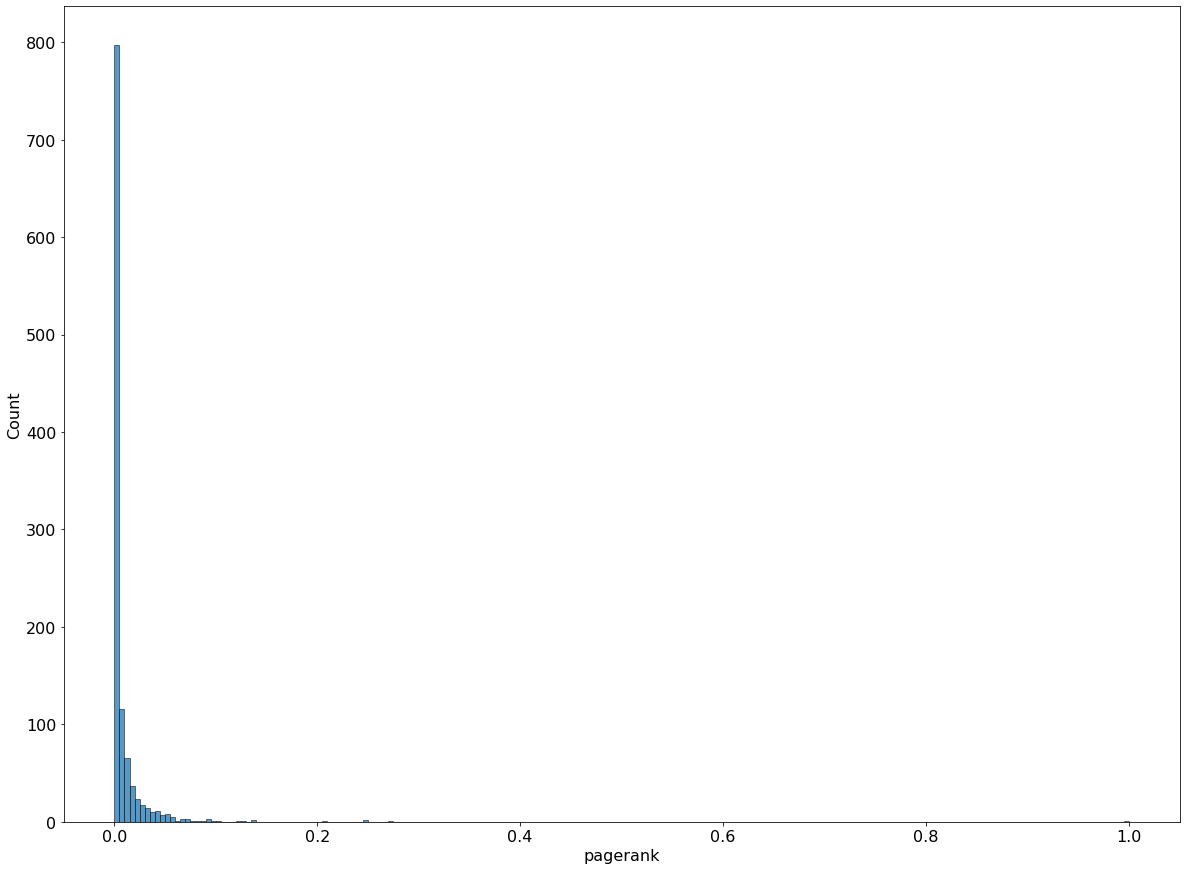

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots()
fig.set_figheight(15)
fig.set_figwidth(20)
chart = sns.histplot(train_df, x="pagerank", bins=200, ax=ax)
plt.savefig('pagerank_dist.pdf', bbox_inches='tight')
plt.show()

In [31]:
print_label_counts_per_sem_type(train_df, "dsyn")

Semantic Type: Disease or Syndrome
label | count
-------------
    0 |     2
    1 |    12



In [13]:
rankings = zip(test_df.index.tolist(), Y_rank_svm_predict.tolist())

In [14]:
import csv
column_names = ['#', 'cui', 'label', 'ranking', 'target'] + unabrv_feature_name

cui_to_x_test = {cui: X_test[ii, :].tolist() for ii, cui in enumerate(test_df.index)}

with open('final_model_eval.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(column_names)
    writer.writerow(['', '', 'Model Coeficients', '', ''] + rank_svm.coefs.tolist())
    for ii, (cui, ranking) in enumerate(sorted(rankings, key=lambda x: x[1], reverse=True), start=1):
        true_label = "keep" if test_df['target'][cui] == 1 else "discard"
        writer.writerow([ii, cui, test_df['label'][cui], ranking, true_label] + cui_to_x_test[cui])
    